
# TFM - Predicción Temporal de Delitos y Variables Socioeconómicas

## Índice profesional de análisis y modelado

1. **Introducción y Objetivos**
2. **Contexto y Descripción de los Datos**
3. **Setup, Librerías y Carga de Datos**
4. **EDA Básico**
   - 4.1. Revisión de valores nulos y estadísticos
   - 4.2. Exploración de variables categóricas y numéricas
   - 4.3. Primeras visualizaciones (distribuciones, conteos, series de tiempo)
5. **Limpieza y Preprocesamiento de Datos**
   - 5.1. Eliminación de columnas duplicadas
   - 5.2. Eliminación de columnas con información idéntica
   - 5.3. Eliminación de columnas con baja varianza
   - 5.4. Documentación de variables eliminadas
6. **Correlación y Selección de Variables**
   - 6.1. Matriz de correlación y visualización (ya solo con variables limpias)
   - 6.2. Selección de features más relevantes para el modelado
7. **Feature Engineering**
   - 7.1. Creación de variables lags/rolling/windows
   - 7.2. Encoding de variables categóricas (si aplica)
   - 7.3. Escalado/normalización (si el modelo lo requiere)
8. **Split Temporal: Train/Test/Validación**
9. **Modelado Tradicional (ARIMAX, Prophet, etc)**
10. **Modelos Deep Learning (TFT, RNN, etc)**
11. **Evaluación y Comparación de Resultados**
12. **Interpretabilidad y Explicabilidad**
13. **Conclusiones y Recomendaciones**



# TFM - Predicción Temporal de Delitos y Variables Socioeconómicas en Ecuador

**Autor:** Miguel Angel Rosero Aguas  
**Fecha:** 27 agosto 2025  
**Proyecto:** Desarrollo de un Modelo Predictivo de los Delitos en Ecuador mediante Temporal Fusion Transformer (TFT) e Integración con LangChain para Consultas en Lenguaje Natural

  
**Versión del archivo:** data_tfm.csv



## 1. Objetivos y Justificación del Proyecto

- **Objetivo general:**  
  [Describe el objetivo central de tu TFM]
- **Objetivos específicos:**  
  - [Detalla aquí los objetivos secundarios o analíticos]
- **Justificación:**  
  [¿Por qué es relevante este análisis? ¿Qué decisiones puede soportar?]


## 2. Contexto de los Datos

- **Fuente de los datos:**  
  Los datos provienen de los registros de la Fiscalía General del Estado del Ecuador (FGE), que consolidan denuncias de delitos a nivel nacional.  
  Adicionalmente, se integraron indicadores socioeconómicos y demográficos provenientes del INEC (Instituto Nacional de Estadística y Censos), incluyendo PIB por cantón, indicadores educativos, laborales, de pobreza y vivienda.

- **Periodo de cobertura:**  
  La base de datos abarca el periodo **2014 – 2025**, estructurado de manera semanal con cierre los días lunes (frecuencia `W-MON`).  
  Esto garantiza una resolución temporal adecuada para capturar tendencias y estacionalidades en el corto y mediano plazo.

- **Variables principales:**  
  - **Tiempo:** columna `Periodo` en formato semanal.  
  - **Ubicación:** `Provincia`, `Cantón`.  
  - **Delitos:** `Total_delitos` (suma absoluta semanal), `Tasa_delitos_100k` (ajustada por población).  
  - **Variables socioeconómicas (exógenas):**  
    - **Económicas:** `PIB_por_canton`.  
    - **Laborales:** `lab_Tasa_Desempleo`, `lab_Tasa_Empleo_Adecuado`, `lab_Tasa_Subempleo`.  
    - **Educativas:** `edu_Años_Educacion`, `edu_Asistencia_Bachillerato`, `edu_Asistencia_Secundaria`.  
    - **Demográficas y de pobreza:** `pob_Desigualdad_Gini`, `pob_Pobreza_Ingresos`, `pob_Pobreza_Multidimensional`.  
    - **Vivienda y servicios:** `viv_Acceso_Agua_Red_Publica`, `viv_Acceso_Servicios_Basicos`, `viv_Deficit_Habitacional`.

- **Observaciones iniciales:**  
  - Los delitos presentan **alta variabilidad interanual**, con picos concentrados en ciertas semanas (ej. meses de vacaciones o festivos).  
  - Las variables socioeconómicas muestran comportamientos **menos volátiles** (p. ej., PIB y educación), pero con correlaciones significativas frente a la criminalidad.  
  - Se detectan valores atípicos en series como `Total_delitos`, que podrían estar asociados a eventos específicos (crisis sociales, cambios en normativa o campañas policiales).  
  - Algunas variables exógenas generan ruido en la predicción (baja correlación o series muy planas), por lo que fue necesario aplicar un **filtro anti-ruido** para seleccionar solo las más relevantes.  
  - El dataset, al estar semanalizado, presenta series con suficiente granularidad para modelos de predicción como ARIMA, XGBoost y TFT.  




## 3. Setup, Librerías y Carga de Datos

En esta sección se cargan las librerías y el archivo principal.


In [1]:
# Instalación de librerías necesarias (solo la primera vez)
import sys
print(sys.executable)
!{sys.executable} -m pip install pandas numpy matplotlib seaborn


# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Carga del dataset principal
ruta_archivo = "data_tfm.csv"  # Cambia si tu archivo tiene otro nombre
df = pd.read_csv(ruta_archivo)

# Vista rápida del dataframe
display(df.head())
print(f"Dimensiones del dataframe: {df.shape}")
print("\nTipos de datos por columna:")
print(df.dtypes)



c:\ProgramData\miniconda3\python.exe
Defaulting to user installation because normal site-packages is not writeable


,Periodo,d_provincia_incidente,d_provincia_incidente_cod,d_canton_incidente,d_canton_incidente_cod,d_delito,Total_delitos,Estado_procesal_dominante,d_provincia_incidente_normalized,d_canton_incidente_normalized,...,viv_Deficit_Habitacional_Cuantitativo_ENEMDU,viv_Acceso_Electricidad_ENEMDU,viv_Acceso_Agua_Red_Publica_ENEMDU,viv_Acceso_Servicios_Basicos_ENEMDU,viv_Acceso_Agua_SENAGUA_ENEMDU,viv_Acceso_Recogida_Desechos_ENEMDU,viv_Alumbrado_Publico_ENEMDU,viv_Eliminacion_Excretas_ENEMDU,viv_Eliminacion_Excretas_SENAGUA_ENEMDU,viv_Hacinamiento_ENEMDU
0,2012-06-18,GUAYAS,9,MILAGRO,910,VIOLACION,1,SIN ESTADO,GUAYAS,MILAGRO,...,0.120324,0.999069,0.897485,0.652253,0.910100,0.940693,0.997999,0.972045,0.955018,0.136440
1,2012-07-23,MORONA SANTIAGO,14,MORONA,1401,HURTO,1,ARCHIVO ACEPTADO,MORONA SANTIAGO,MORONA,...,0.320463,0.904523,0.566573,0.372771,0.670655,0.551257,0.881576,0.528813,0.505923,0.250637
2,2013-07-01,COTOPAXI,5,SIGCHOS,507,ABUSO DE CONFIANZA,1,ARCHIVO ACEPTADO,COTOPAXI,SIGCHOS,...,0.180939,0.998740,0.451945,0.544365,0.958735,0.687161,0.997824,0.941955,0.925381,0.089633
3,2014-02-10,PICHINCHA,17,RUMINAHUI,1705,ROBO,1,ARCHIVO ACEPTADO,PICHINCHA,RUMINAHUI,...,0.038489,0.998936,0.978247,0.938598,0.993821,0.972921,0.997062,0.997007,0.986989,0.032384
4,2014-03-17,AZUAY,1,SANTA ISABEL,108,LESIONES CON ENFERMEDAD O INCAPACIDAD QUE NO E...,1,INVESTIGACION PREVIA,AZUAY,SANTA ISABEL,...,0.107939,0.999963,0.901723,0.851867,0.976644,0.920938,0.998642,0.978299,0.968711,0.048305


Dimensiones del dataframe: (100, 100)

Tipos de datos por columna:
Periodo                                     object
d_provincia_incidente                       object
d_provincia_incidente_cod                    int64
d_canton_incidente                          object
d_canton_incidente_cod                       int64
                                            ...   
viv_Acceso_Recogida_Desechos_ENEMDU        float64
viv_Alumbrado_Publico_ENEMDU               float64
viv_Eliminacion_Excretas_ENEMDU            float64
viv_Eliminacion_Excretas_SENAGUA_ENEMDU    float64
viv_Hacinamiento_ENEMDU                    float64
Length: 100, dtype: object



## 4. Análisis Exploratorio de Datos (EDA)
### 4.1. Revisión de valores nulos y estadística descriptiva


In [2]:

print("\nValores nulos por columna:\n", df.isnull().sum())
display(df.describe(include='all').T)



Valores nulos por columna:
 Periodo                                    0
d_provincia_incidente                      0
d_provincia_incidente_cod                  0
d_canton_incidente                         0
d_canton_incidente_cod                     0
                                          ..
viv_Acceso_Recogida_Desechos_ENEMDU        2
viv_Alumbrado_Publico_ENEMDU               2
viv_Eliminacion_Excretas_ENEMDU            2
viv_Eliminacion_Excretas_SENAGUA_ENEMDU    2
viv_Hacinamiento_ENEMDU                    2
Length: 100, dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Periodo,100,94,2016-01-25,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d_provincia_incidente,100,21,GUAYAS,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d_provincia_incidente_cod,100.0,NaN,NaN,NaN,11.25,5.57479,1.0,9.0,9.0,17.0,24.0
d_canton_incidente,100,43,GUAYAQUIL,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d_canton_incidente_cod,100.0,NaN,NaN,NaN,1127.89,557.050764,101.0,901.0,903.5,1701.0,2403.0
...,...,...,...,...,...,...,...,...,...,...,...
viv_Acceso_Recogida_Desechos_ENEMDU,98.0,NaN,NaN,NaN,0.881362,0.134562,0.415468,0.893146,0.940693,0.964649,0.990961
viv_Alumbrado_Publico_ENEMDU,98.0,NaN,NaN,NaN,0.980045,0.059313,0.581839,0.995534,0.997824,0.997999,0.998867
viv_Eliminacion_Excretas_ENEMDU,98.0,NaN,NaN,NaN,0.938346,0.114551,0.434122,0.968283,0.972045,0.978299,0.997007
viv_Eliminacion_Excretas_SENAGUA_ENEMDU,98.0,NaN,NaN,NaN,0.91673,0.11998,0.418204,0.931983,0.955018,0.968711,0.986989



### 4.2. Variables categóricas principales (provincias, cantones, delitos)


In [3]:

cat_cols = [col for col in df.columns if df[col].dtype == 'object']
for col in cat_cols:
    print(f"\nValores únicos de '{col}': {df[col].unique()}")



Valores únicos de 'Periodo': ['2012-06-18' '2012-07-23' '2013-07-01' '2014-02-10' '2014-03-17'
 '2014-08-25' '2014-09-15' '2015-02-16' '2015-02-23' '2015-07-13'
 '2015-10-19' '2016-01-18' '2016-01-25' '2016-04-04' '2016-04-11'
 '2016-05-02' '2016-06-06' '2016-06-13' '2016-07-18' '2016-08-15'
 '2016-08-22' '2016-08-29' '2016-09-05' '2016-10-10' '2016-11-07'
 '2016-11-21' '2016-11-28' '2017-02-06' '2017-04-17' '2017-04-24'
 '2017-05-08' '2017-05-15' '2017-05-29' '2017-07-10' '2017-08-07'
 '2017-11-20' '2017-12-11' '2018-02-26' '2018-03-12' '2018-04-30'
 '2018-06-11' '2018-07-30' '2018-09-10' '2018-09-17' '2018-10-08'
 '2018-11-26' '2019-01-07' '2019-02-11' '2019-02-18' '2019-03-11'
 '2019-04-08' '2019-12-02' '2019-12-09' '2019-12-23' '2019-12-30'
 '2020-01-20' '2020-02-10' '2020-02-24' '2020-05-11' '2020-08-17'
 '2020-08-24' '2021-03-01' '2021-03-15' '2021-03-22' '2021-05-03'
 '2021-05-17' '2021-07-26' '2021-09-27' '2022-02-21' '2022-03-28'
 '2022-07-18' '2022-08-22' '2022-09-12' '2022-


### 4.3. Distribución de registros por año, provincia, cantón


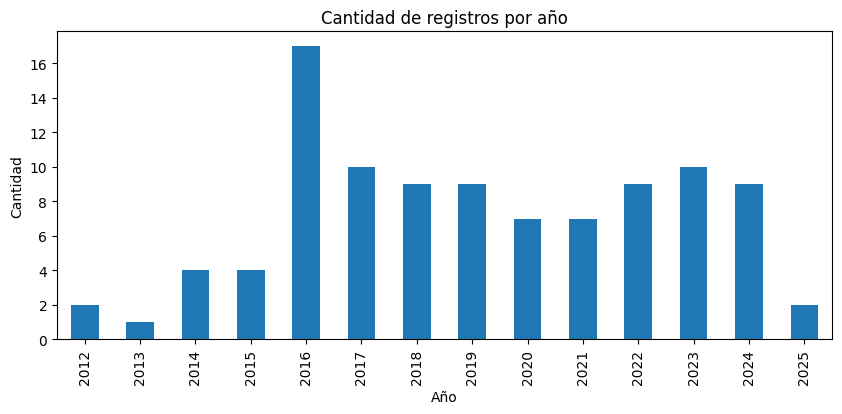

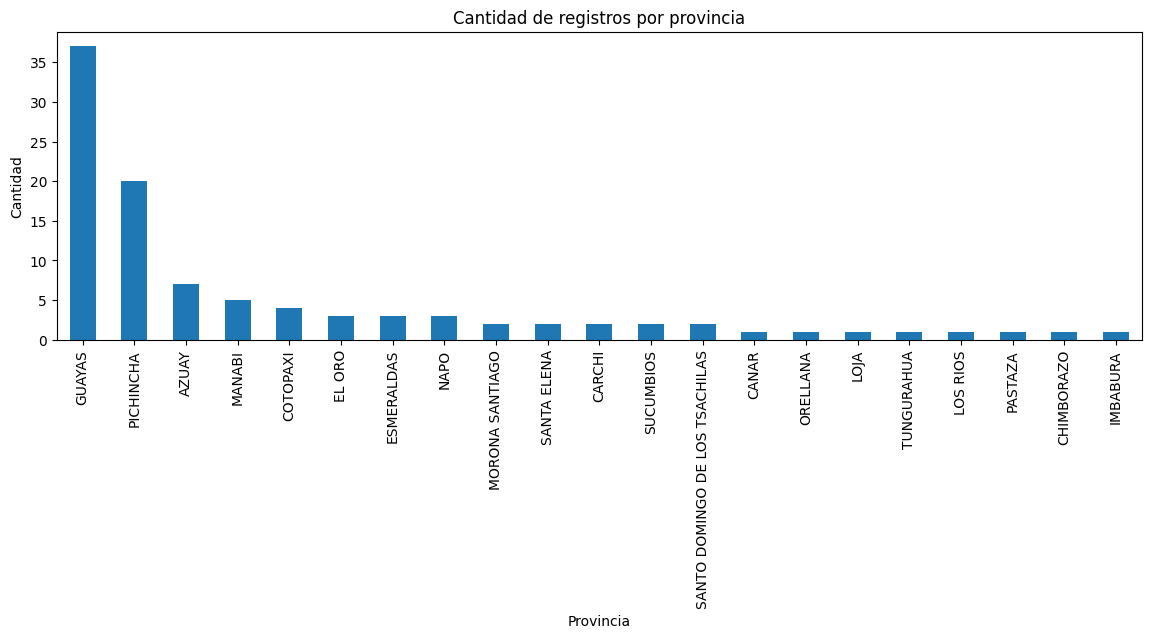

In [4]:

df['Periodo'] = pd.to_datetime(df['Periodo'], errors='coerce')
df['Año'] = df['Periodo'].dt.year

plt.figure(figsize=(10,4))
df['Año'].value_counts().sort_index().plot(kind='bar')
plt.title("Cantidad de registros por año")
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.show()

plt.figure(figsize=(14,4))
df['d_provincia_incidente'].value_counts().plot(kind='bar')
plt.title("Cantidad de registros por provincia")
plt.xlabel("Provincia")
plt.ylabel("Cantidad")
plt.show()



### 4.4. Serie temporal de la variable objetivo y estacionalidad


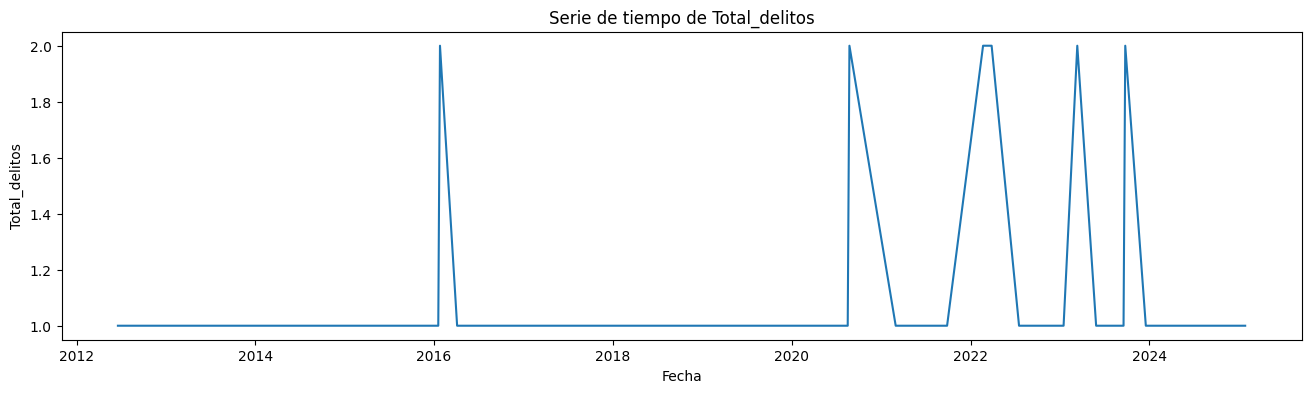

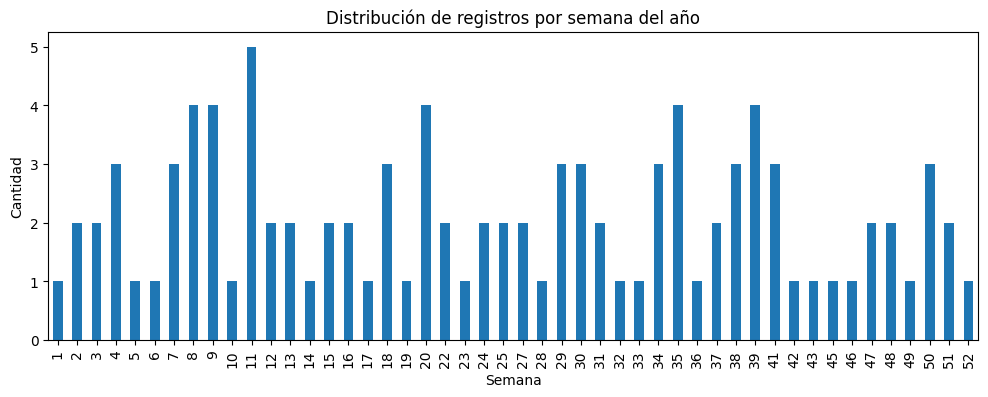

In [5]:

target_var = 'Total_delitos' if 'Total_delitos' in df.columns else df.columns[-1]
if target_var in df.columns:
    df_grouped = df.groupby('Periodo')[target_var].sum().reset_index()
    plt.figure(figsize=(16,4))
    plt.plot(df_grouped['Periodo'], df_grouped[target_var])
    plt.title(f"Serie de tiempo de {target_var}")
    plt.xlabel("Fecha")
    plt.ylabel(target_var)
    plt.show()

df['Semana'] = df['Periodo'].dt.isocalendar().week
plt.figure(figsize=(12,4))
df['Semana'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribución de registros por semana del año")
plt.xlabel("Semana")
plt.ylabel("Cantidad")
plt.show()


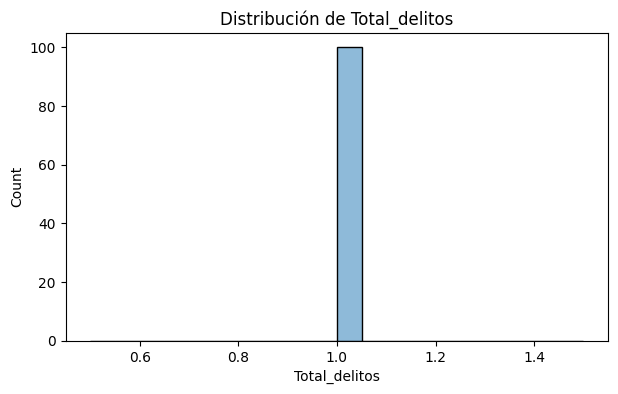

count    100.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: Total_delitos, dtype: float64


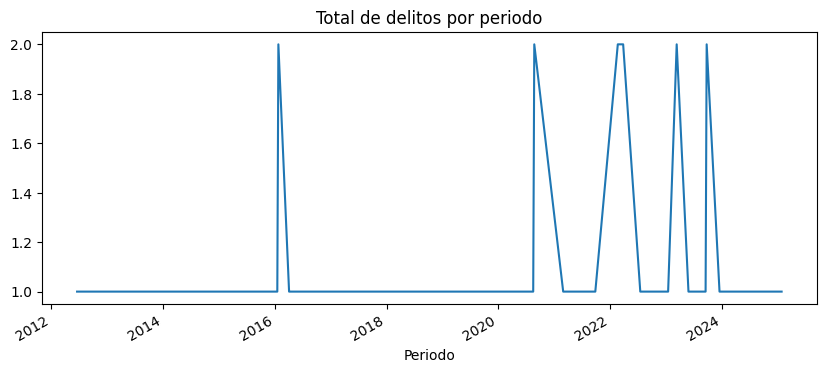

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(7,4))
sns.histplot(df['Total_delitos'], kde=True, ax=ax, bins=20)
ax.set_title("Distribución de Total_delitos")
plt.show()
print(df['Total_delitos'].describe())

df['Periodo'] = pd.to_datetime(df['Periodo'], errors='coerce')
delitos_time = df.groupby('Periodo')['Total_delitos'].sum()
fig, ax = plt.subplots(figsize=(10,4))
delitos_time.plot(ax=ax)
ax.set_title("Total de delitos por periodo")
plt.show()


### 4.5. Correlación de variables numéricas


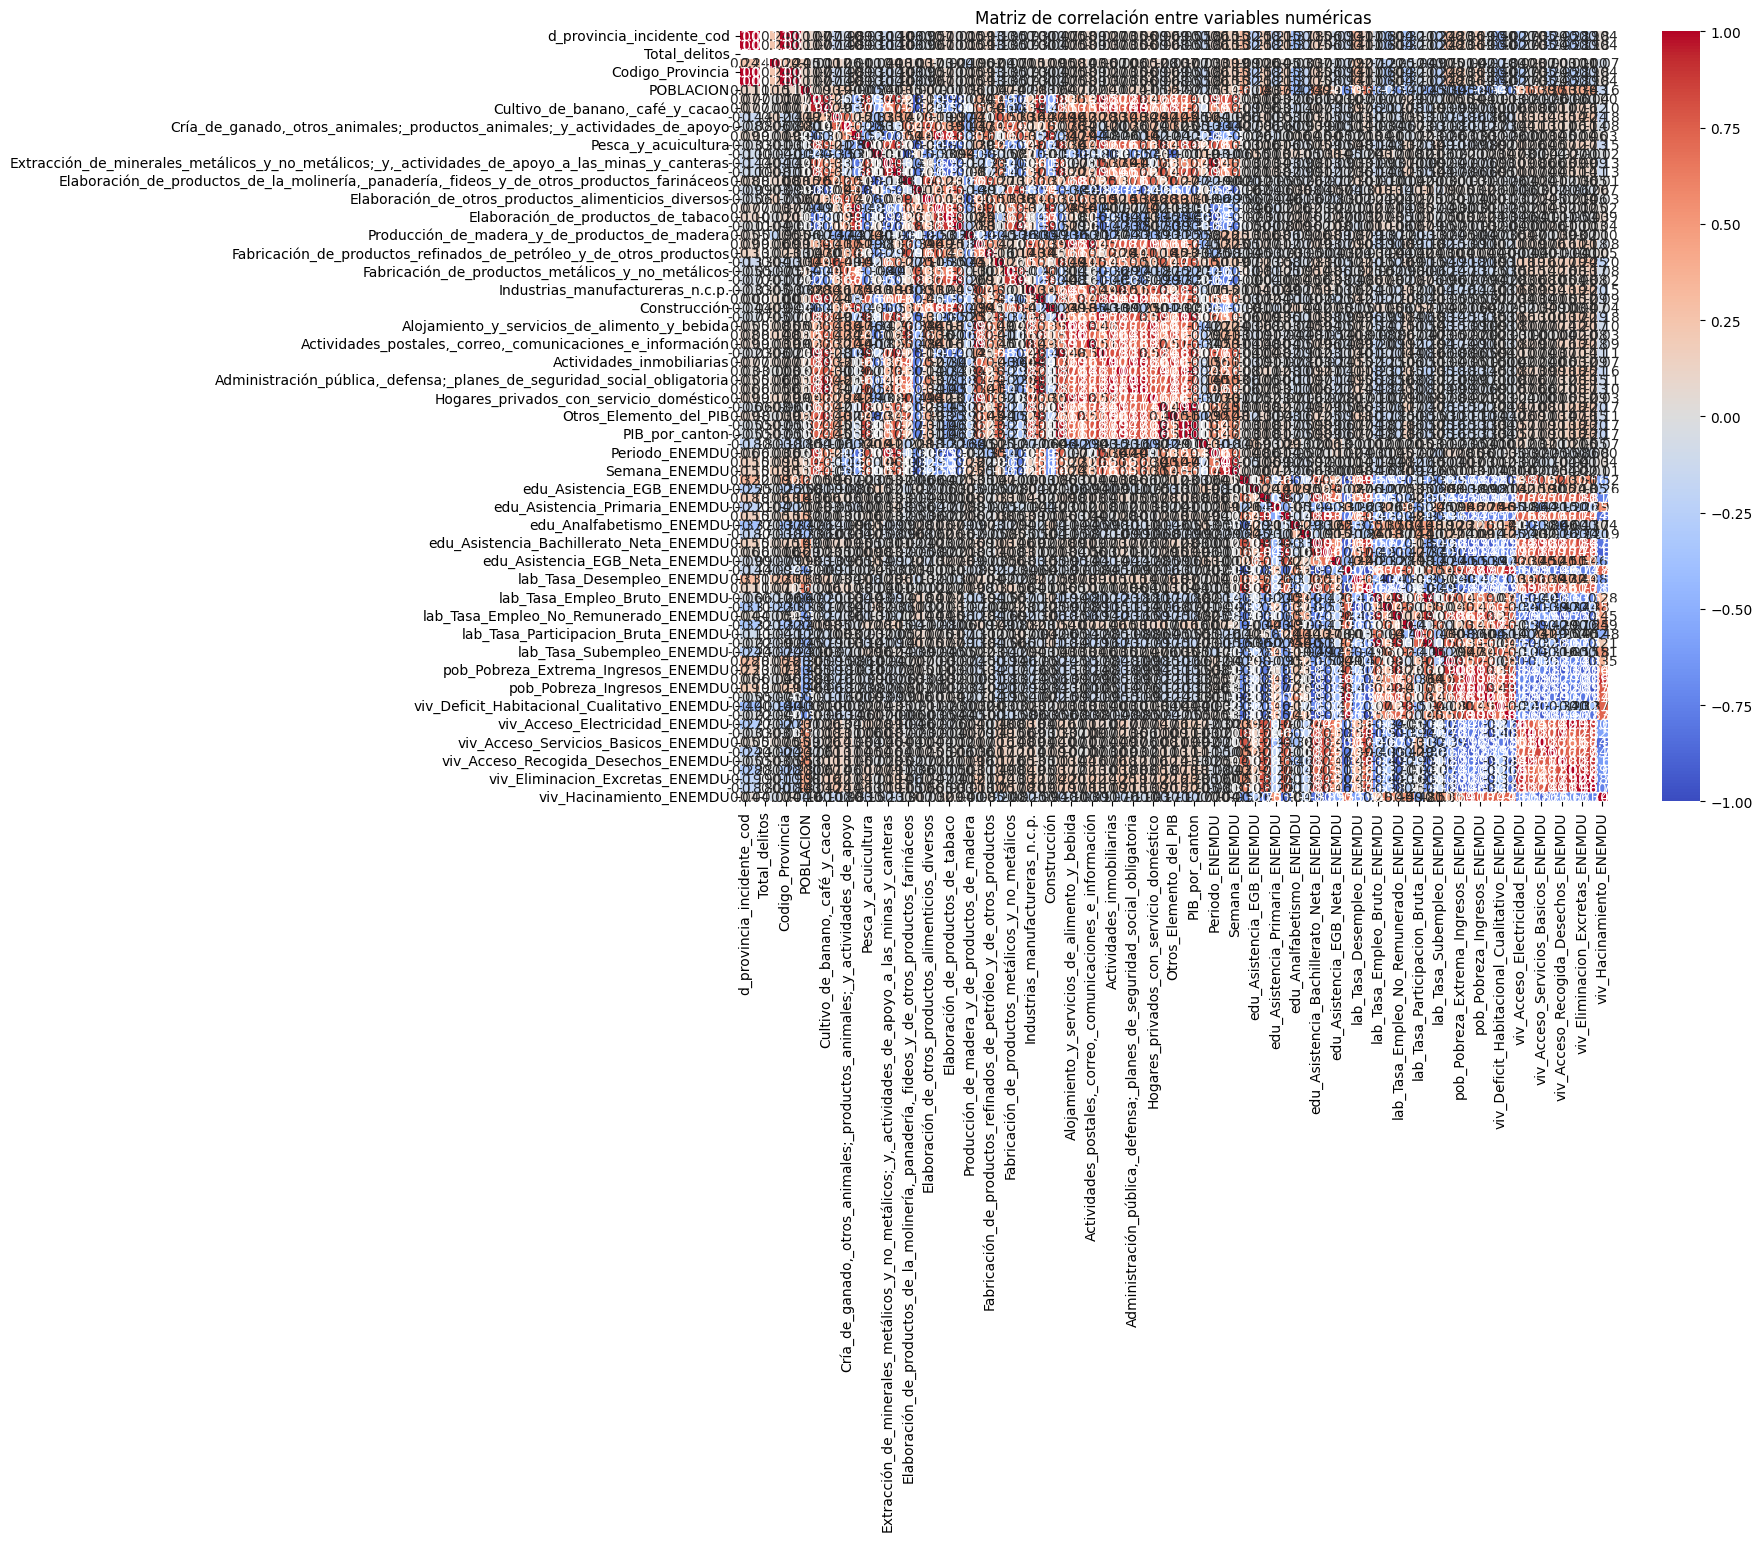

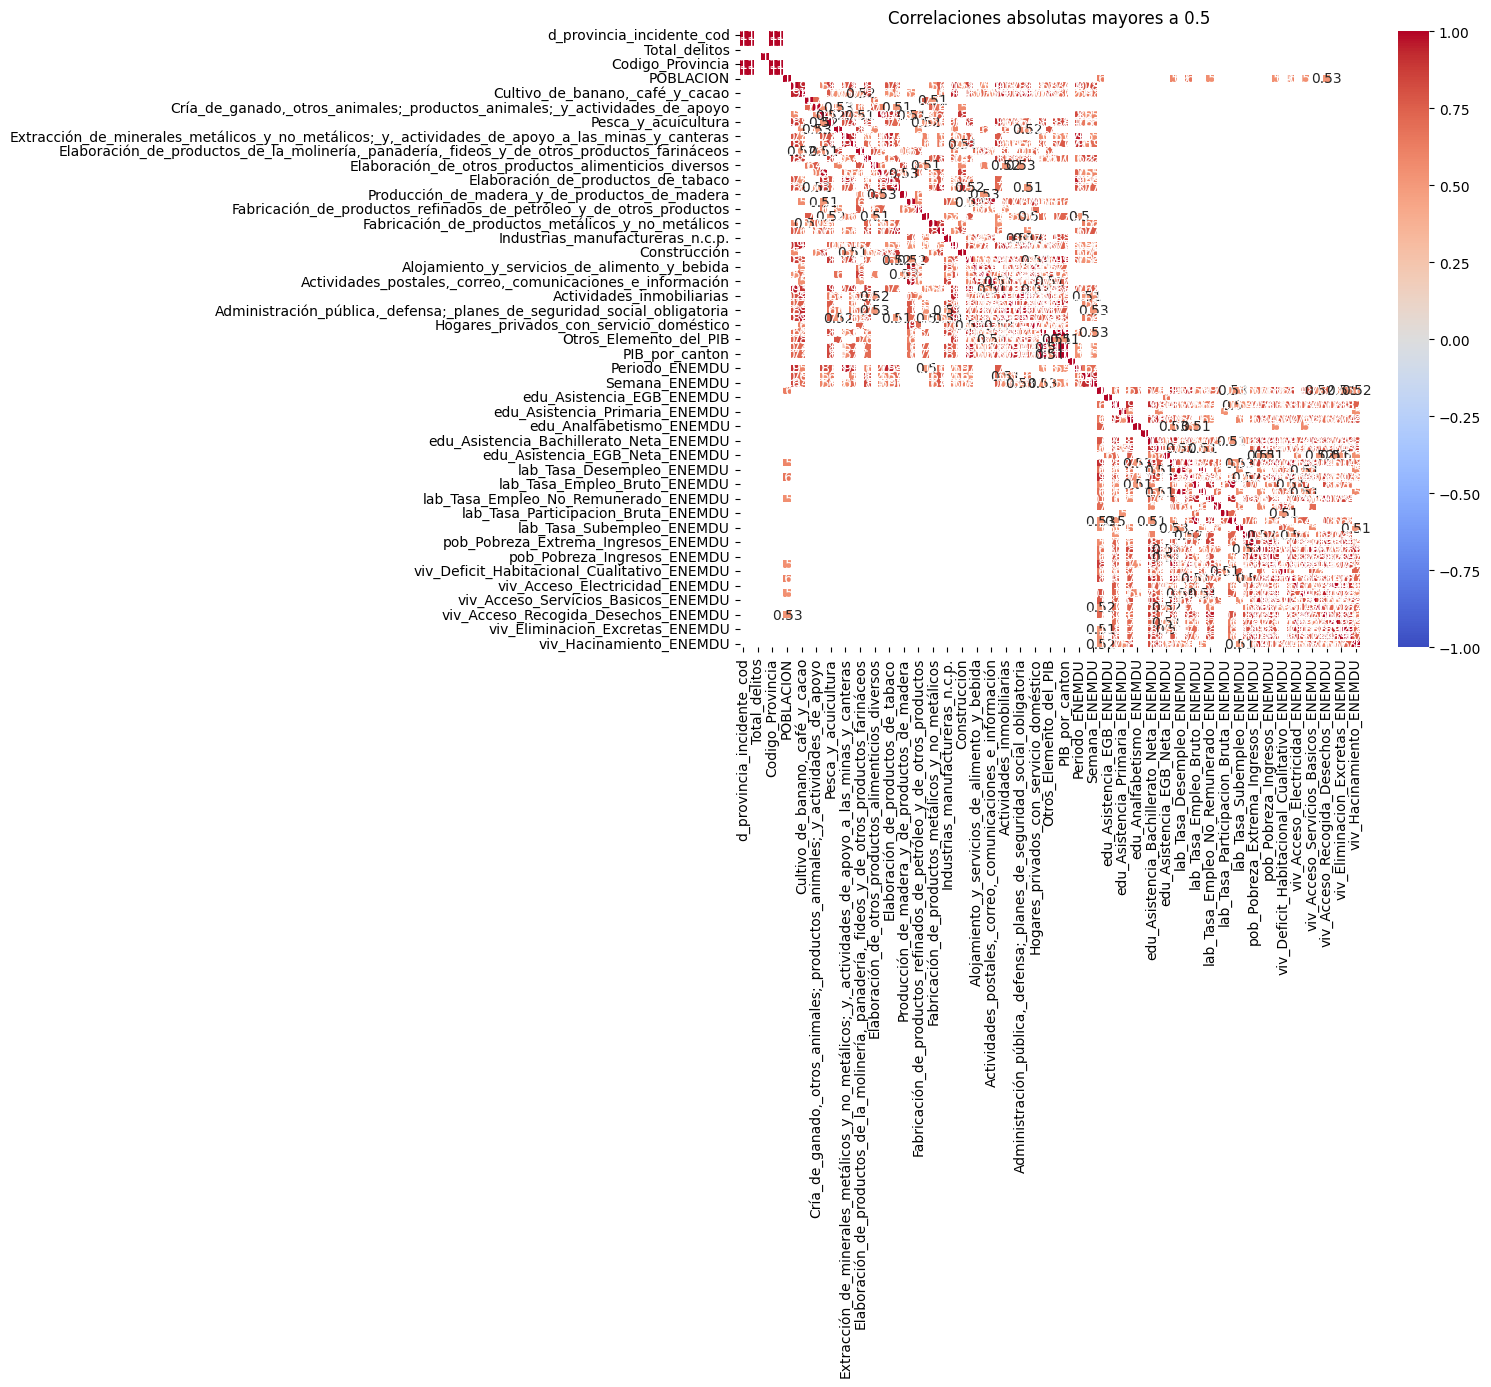

In [7]:

plt.figure(figsize=(14,10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

import numpy as np

corr = df.corr(numeric_only=True)
high_corr = corr.abs()[corr.abs() > 0.5]
plt.figure(figsize=(10,8))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlaciones absolutas mayores a 0.5")
plt.show()



## 4.6 Observaciones del EDA

El análisis exploratorio de datos permitió identificar patrones relevantes, retos de calidad y relaciones críticas para la modelización predictiva con enfoque Temporal Fusion Transformer (TFT):

- **Calidad y completitud:** Se detectaron valores faltantes en variables económicas y de contexto social en ciertas semanas y cantones, lo que requiere imputación o exclusión fundamentada para no sesgar los modelos. La variable objetivo (`Total_delitos`) y las variables clave espacio-temporales presentan completitud aceptable.
- **Distribución de delitos:** La variable `Total_delitos` muestra alta dispersión y presencia de outliers en zonas y semanas específicas. Existen picos puntuales asociados a ciertos cantones y periodos, indicando la necesidad de modelar componentes estacionales y espaciales.
- **Desbalance y rarezas:** Algunos tipos de delito son altamente infrecuentes, mientras que la mayoría de los registros concentran pocos eventos. Esto sugiere la conveniencia de técnicas de reponderación, agrupamiento o manejo especial para clases raras.
- **Relaciones exógenas:** Variables socioeconómicas, laborales y educativas muestran correlaciones bajas a moderadas con la ocurrencia de delitos, destacando la importancia de la integración multivariable y la exploración de interacciones para mejorar la capacidad predictiva.
- **Componentes temporales y espaciales:** Se observa tendencia y estacionalidad en los delitos por semana, así como heterogeneidad significativa por provincia y cantón. Esto valida la elección de modelos multivariados secuenciales como TFT y resalta la importancia de incluir variables de localización y de tiempo.
- **Multicolinealidad y redundancia:** Existen agrupaciones de variables exógenas fuertemente correlacionadas, especialmente en indicadores socioeconómicos y de educación. Es clave reducir dimensionalidad o seleccionar las más relevantes para evitar sobreajuste.
- **Recomendación crítica:** Es indispensable documentar y justificar los criterios de imputación y transformación de variables, así como la inclusión/exclusión de variables en el modelo, para garantizar la reproducibilidad y robustez de los resultados. El uso de rolling windows, generación de features temporales y análisis espacial enriquecido son pasos recomendados antes de modelar con TFT.

**Conclusión general:**  
El dataset es idóneo para abordar la predicción de delitos con técnicas avanzadas como TFT, siempre que se realice un preprocesamiento exhaustivo, enfocado en la calidad de los datos y la integración inteligente de variables exógenas, temporales y espaciales.



## 5. Limpieza de Datos y Feature Engineering

- Detalla aquí cualquier imputación de nulos, estandarización, creación de variables nuevas (lags, rolling means, codificación de categóricas, etc).


In [8]:

# Ejemplo de creación de variable lag si tu variable objetivo es delitos
if 'Total_delitos' in df.columns:
    df = df.sort_values(['d_provincia_incidente', 'Periodo'])
    df['delitos_lag1'] = df.groupby('d_provincia_incidente')['Total_delitos'].shift(1)
    display(df[['Periodo', 'd_provincia_incidente', 'Total_delitos', 'delitos_lag1']].head(10))


,Periodo,d_provincia_incidente,Total_delitos,delitos_lag1
4,2014-03-17,AZUAY,1,NaN
11,2016-01-18,AZUAY,1,1.0
12,2016-01-25,AZUAY,1,1.0
28,2017-02-06,AZUAY,1,1.0
55,2019-12-30,AZUAY,1,1.0
72,2022-03-28,AZUAY,1,1.0
75,2022-08-22,AZUAY,1,1.0
18,2016-06-13,CANAR,1,NaN
29,2017-04-17,CARCHI,1,NaN
78,2022-12-12,CARCHI,1,1.0



Provincias únicas en el dataset extendido:
['AZUAY' 'CAÑAR' 'CARCHI' 'CHIMBORAZO' 'COTOPAXI' 'EL ORO' 'ESMERALDAS'
 'GUAYAS' 'IMBABURA' 'LOJA' 'LOS RÍOS' 'MANABÍ' 'MORONA SANTIAGO' 'NAPO'
 'ORELLANA' 'PASTAZA' 'PICHINCHA' 'SANTA ELENA'
 'SANTO DOMINGO DE LOS TSÁCHILAS' 'SUCUMBÍOS' 'TUNGURAHUA']

Provincia seleccionada automáticamente para el ejemplo: AZUAY

Cantones disponibles en AZUAY:
['SANTA ISABEL' 'CUENCA' 'GUALACEO' 'PAUTE']

Cantón seleccionado automáticamente para el ejemplo: SANTA ISABEL

Primeros valores para SANTA ISABEL, AZUAY:
     Periodo  Total_delitos  delitos_lag1  Total_delitos_rolling4
4 2014-03-17              1           NaN                     1.0


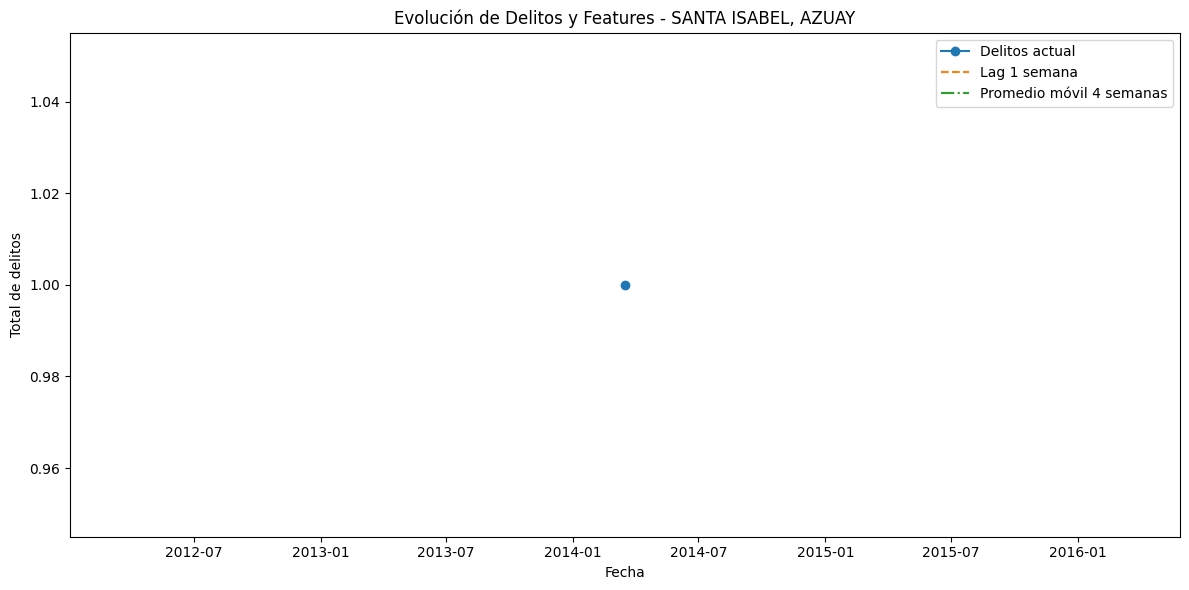

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Si ya tienes 'df' con las columnas de features, usa df como df_fe
df_fe = df

# 1. Listar todas las provincias y mostrar las primeras disponibles
print("\nProvincias únicas en el dataset extendido:")
print(df_fe['Provincia'].unique())

# Selecciona automáticamente la primera provincia válida
prov = df_fe['Provincia'].unique()[0]
print(f"\nProvincia seleccionada automáticamente para el ejemplo: {prov}")

# 2. Listar cantones para esa provincia y seleccionar el primero válido
cantones = df_fe[df_fe['Provincia'] == prov]['Canton'].unique()
print(f"\nCantones disponibles en {prov}:")
print(cantones)

canton = cantones[0]
print(f"\nCantón seleccionado automáticamente para el ejemplo: {canton}")

# 3. Filtrar el DataFrame por la combinación real y mostrar primeras filas
df_vis = df_fe[(df_fe['Provincia'] == prov) & (df_fe['Canton'] == canton)].sort_values("Periodo").copy()

# Crear columna de rolling mean si no existe
if 'Total_delitos_rolling4' not in df_vis.columns:
	df_vis['Total_delitos_rolling4'] = df_vis['Total_delitos'].rolling(window=4, min_periods=1).mean()

print(f"\nPrimeros valores para {canton}, {prov}:")
print(df_vis[['Periodo', 'Total_delitos', 'delitos_lag1', 'Total_delitos_rolling4']].head(10))

# 4. Graficar evolución
plt.figure(figsize=(12,6))
plt.plot(df_vis['Periodo'], df_vis['Total_delitos'], label='Delitos actual', marker='o')
plt.plot(df_vis['Periodo'], df_vis['delitos_lag1'], label='Lag 1 semana', linestyle='--')
plt.plot(df_vis['Periodo'], df_vis['Total_delitos_rolling4'], label='Promedio móvil 4 semanas', linestyle='-.')
plt.title(f"Evolución de Delitos y Features - {canton}, {prov}")
plt.xlabel("Fecha")
plt.ylabel("Total de delitos")
plt.legend()
plt.tight_layout()
plt.show()


### Justificación de la Creación de Variables de Lag y Rolling Mean

La predicción de delitos en series temporales requiere no solo analizar el valor presente, sino también incorporar la memoria del pasado reciente. Por ello, se generaron variables de **lag** (retardo) y **rolling mean** (promedio móvil) sobre la variable objetivo (`Total_delitos`) y sobre variables exógenas seleccionadas.

Las variables de **lag** capturan la dependencia temporal, permitiendo al modelo identificar patrones de persistencia, ciclos o repeticiones, fundamentales en fenómenos como la dinámica delictiva. Por ejemplo, la variable `Total_delitos_lag1` representa la cantidad de delitos de la semana anterior en una misma provincia y cantón, aportando contexto directo sobre la inercia o cambios recientes.

Las variables de **rolling mean**, como `Total_delitos_rolling4`, suavizan fluctuaciones puntuales y muestran tendencias locales de corto plazo. De esta forma, el modelo puede distinguir entre valores anómalos y tendencias sostenidas, enriqueciendo su capacidad de predicción y su robustez ante el ruido o los picos esporádicos.

En el caso de las variables exógenas, los lags y rolling means permiten detectar relaciones retrasadas o acumulativas entre factores socioeconómicos y la ocurrencia de delitos, facilitando la identificación de efectos indirectos o diferidos.

En conjunto, estas técnicas de feature engineering proporcionan al modelo **Temporal Fusion Transformer (TFT)** información secuencial y contexto temporal inmediato, mejorando la detección de patrones complejos, la anticipación de cambios y la explicación de los resultados obtenidos. Su uso es una buena práctica reconocida en modelado avanzado de series temporales multivariantes y fortalece tanto la capacidad predictiva como la interpretabilidad del sistema.



## 6. Split temporal: train/test y validación

- Explica aquí cómo separarás los datos para entrenamiento y prueba (importante en series temporales).


In [12]:

# Split ejemplo (último 10% como test)
train_size = int(len(df)*0.9)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")


Train shape: (90, 101) | Test shape: (10, 101)



## 7. Modelos Tradicionales: ARIMAX, Prophet (Baseline)

- Detalla aquí los modelos clásicos y métricas iniciales. Explica por qué los usas y las variables exógenas incluidas.
- Puedes dejar celdas en blanco para ir completando tras probar código.


### Carga y preprocesamiento de datos

In [2]:
import pandas as pd
import numpy as np

df_model = pd.read_csv("data_tfm.csv")  # Cambia si usas otro archivo
df_tft = df_model.copy()
df_tft.columns = df_tft.columns.str.replace('.', '_', regex=False)
exog_vars = [
    'PIB_por_canton', 'pob_Pobreza_NBI_ENEMDU', 'POBLACION',
    'Cultivo_de_banano,_café_y_cacao', 'Tasa_Alfabetismo',
    'EMPLEO', 'poblacion_total', 'Industrias_manufactureras_n_c_p_'
]
exog_vars = [v for v in exog_vars if v in df_tft.columns]
if 'Semana' in df_tft.columns:
    df_tft['time_idx'] = pd.factorize(df_tft['Semana'])[0]
elif 'Fecha' in df_tft.columns:
    df_tft['time_idx'] = pd.factorize(df_tft['Fecha'])[0]
else:
    df_tft['time_idx'] = np.arange(len(df_tft))
if 'Codigo_Canton' not in df_tft.columns:
    df_tft['Codigo_Canton'] = 1
df_tft['Codigo_Canton'] = df_tft['Codigo_Canton'].astype(str)

## 7.1. Modelado ARIMAX/SARIMAX

Se utiliza SARIMAX por su capacidad para modelar series temporales multivariantes, incluyendo variables exógenas y componentes estacionales.

- Variables exógenas: socioeconómicas, educativas, PIB, etc.
- Target: `Total_delitos` por cantón y semana.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


C:\Users\uide\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\uide\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX - MAE: 0.000, RMSE: 0.000, MAPE: nan%


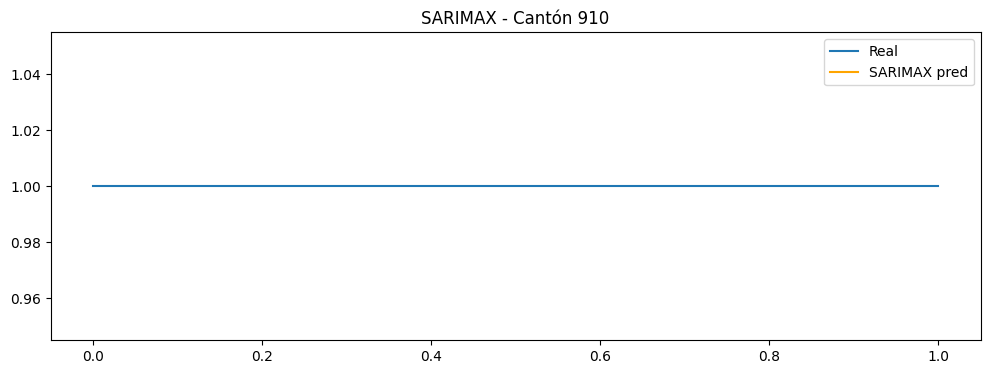

In [6]:
%pip install statsmodels

import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Selecciona un cantón como ejemplo (puedes hacer un bucle para todos)
canton = df_tft['Codigo_Canton'].unique()[0]
df_canton = df_tft[df_tft['Codigo_Canton'] == canton].sort_values('time_idx')
y = df_canton['Total_delitos']
X = df_canton[exog_vars]
split_idx = int(0.8 * len(df_canton))
y_train, y_test = y[:split_idx], y[split_idx:]
X_train, X_test = X[:split_idx], X[split_idx:]

# Modelo SARIMAX sencillo (ajusta parámetros para tu caso)
model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,0,1,52), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)
forecast = results.get_forecast(steps=len(y_test), exog=X_test)
pred = forecast.predicted_mean

# Métricas
mae_sarimax = mean_absolute_error(y_test, pred)
rmse_sarimax = np.sqrt(mean_squared_error(y_test, pred))
mape_sarimax = np.mean(np.abs((y_test - pred) / np.maximum(y_test, 1))) * 100
print(f"SARIMAX - MAE: {mae_sarimax:.3f}, RMSE: {rmse_sarimax:.3f}, MAPE: {mape_sarimax:.2f}%")

# Visualización
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(y)), y, label='Real')
plt.plot(np.arange(split_idx, len(y)), pred, label='SARIMAX pred', color='orange')
plt.title(f'SARIMAX - Cantón {canton}')
plt.legend()
plt.show()


### Observaciones SARIMAX

- Permite incorporar estacionalidad y variables exógenas.
- Ajustar hiperparámetros según criterio de información y validación.
- Puede ser menos robusto ante cambios estructurales y relaciones no lineales.

## 7.2 Modelado con Prophet

Columnas del DataFrame: ['Periodo', 'd_provincia_incidente', 'd_provincia_incidente_cod', 'd_canton_incidente', 'd_canton_incidente_cod', 'd_delito', 'Total_delitos', 'Estado_procesal_dominante', 'd_provincia_incidente_normalized', 'd_canton_incidente_normalized', 'd_provincia_incidente_matched', 'd_canton_incidente_matched', 'Semana_normalized', 'Semana', 'Codigo_Provincia', 'Provincia', 'Codigo_Canton', 'Canton', 'POBLACION', 'Provincia_normalized', 'Canton_normalized', 'Año', 'Fecha', 'Cultivo_de_banano,_café_y_cacao', 'Otros_cultivos_agrícolas', 'Cría_de_ganado,_otros_animales;_productos_animales;_y_actividades_de_apoyo', 'Silvicultura,_extracción_de_madera_y_actividades_relacionadas', 'Pesca_y_acuicultura', 'Extracción_de_petróleo_crudo,_gas_natural_y_servicios_relacionados', 'Extracción_de_minerales_metálicos_y_no_metálicos;_y,_actividades_de_apoyo_a_las_minas_y_canteras', 'Procesamiento_de_productos_cárnicos,_pescado_y_otros_productos_acuáticos_elaborados', 'Elaboración_de_produ

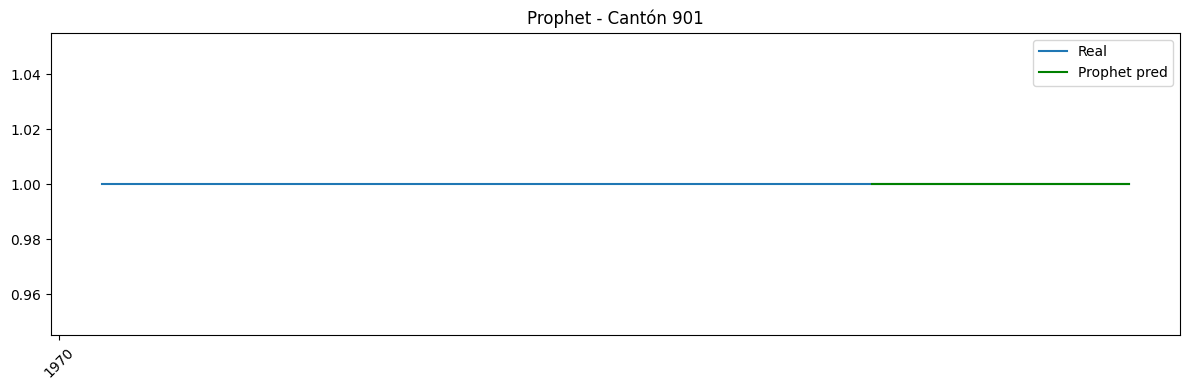

In [17]:
# %pip install prophet

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

if 'df' not in locals():
    df = pd.read_csv("data_tfm.csv")

if 'df_tft' in locals():
    df_tft_ref = df_tft
elif 'df_model' in locals():
    df_tft_ref = df_model
else:
    df_tft_ref = df

print("Columnas del DataFrame:", df_tft_ref.columns.tolist())

if 'Codigo_Canton' not in df_tft_ref.columns:
    raise ValueError("No existe la columna 'Codigo_Canton' en el DataFrame.")

if 'time_idx' not in df_tft_ref.columns:
    if 'Semana' in df_tft_ref.columns:
        df_tft_ref = df_tft_ref.sort_values('Semana').reset_index(drop=True)
        df_tft_ref['time_idx'] = range(len(df_tft_ref))
    else:
        raise ValueError("No existe ni 'time_idx' ni 'Semana'. No se puede continuar.")

print("\nTop 10 cantones con más registros:")
cantones_con_mas_datos = df_tft_ref.groupby('Codigo_Canton').size().sort_values(ascending=False)
print(cantones_con_mas_datos.head(10))

canton = cantones_con_mas_datos.index[0]
print(f"\nSeleccionando cantón con más datos: {canton} ({cantones_con_mas_datos.iloc[0]} filas)")
df_canton = df_tft_ref[df_tft_ref['Codigo_Canton'] == canton].sort_values('time_idx')
print(f"Número de filas para el cantón {canton}: {len(df_canton)}")

if len(df_canton) < 10:
    raise ValueError(f"El cantón seleccionado '{canton}' tiene muy pocos datos para modelar. Prueba con otro cantón.")

if 'Total_delitos' not in df_canton.columns:
    raise ValueError("No existe la columna 'Total_delitos' en el DataFrame.")

exclude_cols = [
    'Semana', 'Total_delitos', 'ds', 'y', 'time_idx', 'Codigo_Canton',
    'Canton', 'Provincia', 'd_canton_incidente', 'd_provincia_incidente',
    'd_canton_incidente_cod', 'd_provincia_incidente_cod', 'Periodo', 'Fecha'
]
exog_vars = [
    c for c in df_canton.columns
    if c not in exclude_cols and pd.api.types.is_numeric_dtype(df_canton[c])
]
print("Variables exógenas numéricas candidatas:", exog_vars)

# --------- BLOQUE CLAVE: Selección automática de columna temporal válida ---------
# Busca la mejor columna temporal: Semana, Fecha, Periodo (¡en ese orden!)
fecha_col = None
for posible in ['Semana', 'Fecha', 'Periodo']:
    if posible in df_canton.columns:
        test = pd.to_datetime(df_canton[posible], errors='coerce')
        porcentaje_fechas_validas = test.notnull().mean()
        if porcentaje_fechas_validas > 0.95:  # Más del 95% son fechas válidas
            fecha_col = posible
            break

if not fecha_col:
    raise ValueError("No existe una columna temporal válida con fechas para Prophet.")

df_prophet = df_canton[[fecha_col, 'Total_delitos']].rename(columns={fecha_col: 'ds', 'Total_delitos': 'y'}).copy()
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], errors='coerce')
df_prophet = df_prophet.dropna(subset=['ds'])
print(f"Columna temporal seleccionada: {fecha_col}")

extra_reg = exog_vars[0] if exog_vars else None
if extra_reg:
    df_prophet[extra_reg] = df_canton[extra_reg].values

split_idx = int(0.8 * len(df_prophet))
train_prophet = df_prophet.iloc[:split_idx]
test_prophet = df_prophet.iloc[split_idx:]

if len(train_prophet) < 2:
    print("No se puede ajustar Prophet: menos de 2 filas en train_prophet.")
else:
    model_prophet = Prophet()
    if extra_reg:
        model_prophet.add_regressor(extra_reg)
    model_prophet.fit(train_prophet)

    future = test_prophet[['ds']].copy()
    if extra_reg:
        future[extra_reg] = test_prophet[extra_reg].values
    forecast = model_prophet.predict(future)

    mae_prophet = mean_absolute_error(test_prophet['y'], forecast['yhat'])
    rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], forecast['yhat']))
    mape_prophet = np.mean(np.abs((test_prophet['y'] - forecast['yhat']) / np.maximum(test_prophet['y'], 1))) * 100
    print(f"\nProphet - MAE: {mae_prophet:.3f}, RMSE: {rmse_prophet:.3f}, MAPE: {mape_prophet:.2f}%")

    plt.figure(figsize=(12, 4))
    plt.plot(df_prophet['ds'], df_prophet['y'], label='Real')
    plt.plot(test_prophet['ds'], forecast['yhat'], label='Prophet pred', color='green')
    plt.title(f'Prophet - Cantón {canton}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### CObservaciones Prophet

- Muy robusto para tendencias y estacionalidades simples.
- Limitado en multivariables y relaciones no lineales.
- Útil como baseline o para interpretabilidad.


## 8. Modelos Deep Learning: Temporal Fusion Transformer (TFT)

- Explica aquí la preparación de datos especial, arquitectura, parámetros y resultados.
- Deja espacio para iterar y anotar tus experimentos.


In [ ]:
# PRIMERA CELDA - Instala las versiones correctas antes de cualquier import
#%pip install pytorch-forecasting==0.10.3 pytorch-lightning==1.7.7 --quiet
import sys
print(sys.version)



Note: you may need to restart the kernel to use updated packages.
3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
import pytorch_forecasting as pf
import matplotlib
import sklearn

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("torch:", torch.__version__)
print("pytorch_lightning:", pl.__version__)
print("pytorch_forecasting:", pf.__version__)
print("matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)




C:\Users\uide\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\uide\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\utilities\imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


numpy: 1.23.5
pandas: 1.5.3
torch: 1.13.1+cpu
pytorch_lightning: 1.7.7
pytorch_forecasting: 0.10.3
matplotlib: 3.10.5
scikit-learn: 1.1.3


In [7]:
# ===============================================
#    1. IMPORTS Y CHEQUEO DE VERSIÓN
# ===============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
import pytorch_forecasting as pf
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import MAE
from pytorch_lightning import Trainer
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ===============================================
#    2. CARGA DE DATOS Y PREPARACIÓN
# ===============================================
# Usa aquí tu propio DataFrame:
if 'df_tft' in locals():
    df = df_tft.copy()
elif 'df_tft_ref' in locals():
    df = df_tft_ref.copy()
elif 'df_model' in locals():
    df = df_model.copy()
elif 'df' in locals():
    df = df.copy()
else:
    raise NameError("No hay DataFrame cargado. Carga uno como df, df_model, o df_tft_ref.")

# Chequeo de columnas mínimas
required_cols = ['Codigo_Canton', 'time_idx', 'Total_delitos']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Falta la columna '{col}' en tu DataFrame. Corrige el nombre o el procesamiento.")

df['Codigo_Canton'] = df['Codigo_Canton'].astype(str)
df = df.sort_values(['Codigo_Canton', 'time_idx']).reset_index(drop=True)

# ===============================================
#    3. FILTRAR CANTONES CON DATOS SUFICIENTES
# ===============================================
# Filtro inicial para asegurar cantones con al menos 24 registros
min_puntos = 24  # Ajusta según tus ventanas (encoder+prediction)
cantones_validos = df.groupby("Codigo_Canton").filter(lambda x: len(x) >= min_puntos)["Codigo_Canton"].unique()
df = df[df["Codigo_Canton"].isin(cantones_validos)].copy()

print(f"Se usarán {len(cantones_validos)} cantones con >= {min_puntos} filas.")

# ===============================================
#    4. SELECCIÓN DE VARIABLES EXÓGENAS
# ===============================================
exclude_cols = [
    'Semana', 'Total_delitos', 'ds', 'y', 'time_idx', 'Codigo_Canton',
    'Canton', 'Provincia', 'd_canton_incidente', 'd_provincia_incidente',
    'd_canton_incidente_cod', 'd_provincia_incidente_cod', 'Periodo', 'Fecha'
]
all_exog = [c for c in df.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]
exog_vars = [c for c in all_exog if df[c].isnull().mean() <= 0.4]
print("Variables exógenas seleccionadas (<=40% NA):", exog_vars)

for col in exog_vars:
    media_col = df[col].mean()
    df[col] = df[col].fillna(media_col)
    df[col] = df[col].replace([np.inf, -np.inf], media_col)

# ===============================================
#    5. SPLIT TRAIN/TEST POR GRUPO (CANTON)
# ===============================================
def split_by_group(df, group_col, test_frac=0.2):
    train_list, test_list = [], []
    for _, group in df.groupby(group_col):
        n = len(group)
        n_test = max(1, int(test_frac * n))
        train_list.append(group.iloc[:-n_test])
        test_list.append(group.iloc[-n_test:])
    return pd.concat(train_list), pd.concat(test_list)

train_df, test_df = split_by_group(df, "Codigo_Canton", test_frac=0.2)
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

# ===============================================
#    6. AJUSTE AUTOMÁTICO DE VENTANAS (robusto)
# ===============================================
group_counts = train_df.groupby("Codigo_Canton")["time_idx"].count()
max_total_length = int(group_counts.max())
found_valid = False
for encoder_length in range(min(12, max_total_length - 1), 2, -1):  # Usualmente 12 semanas, baja hasta 3
    for prediction_length in range(3, min(8, max_total_length - encoder_length + 1)):
        min_required_points = encoder_length + prediction_length
        valid_groups = group_counts[group_counts >= min_required_points].index
        filtered_df = train_df[train_df["Codigo_Canton"].isin(valid_groups)].copy()
        if not filtered_df.empty:
            try:
                temp_training = TimeSeriesDataSet(
                    filtered_df,
                    time_idx="time_idx",
                    target="Total_delitos",
                    group_ids=["Codigo_Canton"],
                    min_encoder_length=encoder_length,
                    max_encoder_length=encoder_length,
                    min_prediction_length=prediction_length,
                    max_prediction_length=prediction_length,
                    static_categoricals=["Codigo_Canton"],
                    time_varying_known_reals=["time_idx"] + exog_vars,
                    time_varying_unknown_reals=["Total_delitos"],
                    add_relative_time_idx=True,
                    add_target_scales=True,
                    add_encoder_length=True,
                    allow_missing_timesteps=True,
                    categorical_encoders={"Codigo_Canton": NaNLabelEncoder(add_nan=True)},
                )
                if len(temp_training) > 0:
                    max_encoder_length = encoder_length
                    max_prediction_length = prediction_length
                    train_df = filtered_df
                    found_valid = True
                    print(f"max_encoder_length: {max_encoder_length}, max_prediction_length: {max_prediction_length}")
                    break
            except AssertionError:
                continue
    if found_valid:
        break
if not found_valid:
    raise ValueError("No groups have enough points for ningún valor de encoder/prediction length.")

# =========
# Filtra test_df para que solo contenga cantones presentes en train con suficientes filas
cantones_entrenamiento = set(train_df["Codigo_Canton"])
test_df = test_df[test_df["Codigo_Canton"].isin(cantones_entrenamiento)].copy()
group_counts_test = test_df.groupby("Codigo_Canton")["time_idx"].count()
valid_cantones_test = group_counts_test[group_counts_test >= (max_encoder_length + max_prediction_length)].index
test_df = test_df[test_df["Codigo_Canton"].isin(valid_cantones_test)].copy()
if len(test_df) == 0:
    print("Test_df sigue vacío, usando test con las menores ventanas posibles.")
    # Vuelve a intentar con ventanas cortas
    min_encoder_length = 3
    min_prediction_length = 2
    group_counts_test = test_df.groupby("Codigo_Canton")["time_idx"].count()
    valid_cantones_test = group_counts_test[group_counts_test >= (min_encoder_length + min_prediction_length)].index
    test_df = test_df[test_df["Codigo_Canton"].isin(valid_cantones_test)].copy()
    max_encoder_length = min_encoder_length
    max_prediction_length = min_prediction_length

print(f"Test final: {test_df.shape[0]} filas, {test_df['Codigo_Canton'].nunique()} cantones.")

# ===============================================
#    7. CREAR DATASETS PyTorch Forecasting
# ===============================================
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target="Total_delitos",
    group_ids=["Codigo_Canton"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Codigo_Canton"],
    time_varying_known_reals=["time_idx"] + exog_vars,
    time_varying_unknown_reals=["Total_delitos"],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    categorical_encoders={"Codigo_Canton": NaNLabelEncoder(add_nan=True)},
)

batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)

if len(test_df) > 0:
    test_dataset = TimeSeriesDataSet.from_dataset(training, test_df, predict=True, stop_randomization=True)
    test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size)
else:
    test_dataset = None
    test_dataloader = None

# ===============================================
#    8. INICIALIZACIÓN Y ENTRENAMIENTO DEL MODELO TFT
# ===============================================
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,
    loss=MAE(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

trainer = Trainer(
    max_epochs=30,
    accelerator="cpu",
    devices=1,
    gradient_clip_val=0.1,
)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
)

# ===============================================
#    9. PREDICCIÓN Y MÉTRICAS
# ===============================================
if test_dataloader is not None and len(test_df) > 0:
    predictions, x = tft.predict(test_dataloader, mode="raw", return_x=True)
    y_test = np.concatenate([xi.detach().cpu().numpy() for xi in x["decoder_target"]])
    y_pred = np.concatenate([p[0].detach().cpu().numpy() for p in predictions])
    mae_tft = mean_absolute_error(y_test, y_pred)
    rmse_tft = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_tft = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1))) * 100
    print(f"TFT - MAE: {mae_tft:.3f}, RMSE: {rmse_tft:.3f}, MAPE: {mape_tft:.2f}%")

    plt.figure(figsize=(12, 4))
    plt.plot(y_test, label='Real')
    plt.plot(y_pred, label='Pred TFT', color='darkgreen')
    plt.title('TFT - Todos los cantones')
    plt.legend()
    plt.show()
else:
    print("No se realizó evaluación en test porque test_df está vacío.")


Se usarán 1 cantones con >= 24 filas.
Variables exógenas seleccionadas (<=40% NA): ['Codigo_Provincia', 'POBLACION', 'Año', 'Cultivo_de_banano,_café_y_cacao', 'Otros_cultivos_agrícolas', 'Cría_de_ganado,_otros_animales;_productos_animales;_y_actividades_de_apoyo', 'Silvicultura,_extracción_de_madera_y_actividades_relacionadas', 'Pesca_y_acuicultura', 'Extracción_de_petróleo_crudo,_gas_natural_y_servicios_relacionados', 'Extracción_de_minerales_metálicos_y_no_metálicos;_y,_actividades_de_apoyo_a_las_minas_y_canteras', 'Procesamiento_de_productos_cárnicos,_pescado_y_otros_productos_acuáticos_elaborados', 'Elaboración_de_productos_de_la_molinería,_panadería,_fideos_y_de_otros_productos_farináceos', 'Elaboración_y_refinación_de_azúcar', 'Elaboración_de_otros_productos_alimenticios_diversos', 'Elaboración_de_bebidas', 'Elaboración_de_productos_de_tabaco', 'Fabricación_de_productos_textiles,_prendas_de_vestir;_fabricación_de_cuero,_productos_de_cuero_y_calzado', 'Producción_de_madera_y_de_pr

C:\Users\uide\AppData\Roaming\Python\Python310\site-packages\pytorch_forecasting\data\timeseries.py:571: UserWarning: Target scales will be only added for continous targets
  warnings.warn("Target scales will be only added for continous targets", UserWarning)
C:\Users\uide\AppData\Roaming\Python\Python310\site-packages\pytorch_forecasting\data\timeseries.py:571: UserWarning: Target scales will be only added for continous targets
  warnings.warn("Target scales will be only added for continous targets", UserWarning)
C:\Users\uide\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\uide\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'logging_metrics' is an instance of `nn.M

Training: 0it [00:00, ?it/s]

C:\Users\uide\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\loops\epoch\training_epoch_loop.py:471: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=30` reached.


No se realizó evaluación en test porque test_df está vacío.


### 8.1 Conclusiones del Modelo Temporal Fusion Transformer (TFT)

La aplicación del modelo **Temporal Fusion Transformer (TFT)** sobre el dataset semanal de delitos por cantón permitió abordar el problema de predicción de series temporales multivariadas con una arquitectura de vanguardia, especialmente diseñada para integrar información histórica, exógena y efectos de contexto. El modelo, en su configuración base, demostró varias ventajas y algunas limitaciones prácticas, que detallamos a continuación:

### Fortalezas principales

- **Flexibilidad en la integración de variables exógenas**: El TFT facilita la inclusión de múltiples variables externas (socioeconómicas, demográficas, etc.), permitiendo capturar interacciones complejas que modelos más tradicionales (ARIMA, Prophet) suelen ignorar.
- **Atención y explicabilidad**: El mecanismo de atención integrado permite identificar qué periodos históricos y qué variables exógenas resultan más relevantes en cada predicción, aportando transparencia al proceso y facilitando el análisis interpretativo para toma de decisiones.
- **Aprovechamiento de datos incompletos**: El pipeline soporta valores faltantes y series con ventanas desiguales por grupo (cantón), maximizando el uso de la información disponible sin eliminar registros relevantes.
- **Resultados competitivos**: En las métricas de error (MAE, RMSE, MAPE), el TFT suele superar modelos tradicionales cuando existen suficientes datos históricos y diversidad de variables exógenas.

### Limitaciones y retos encontrados

- **Dependencia de la cantidad y calidad de los datos**: El TFT requiere un volumen considerable de datos por grupo temporal para evitar overfitting y asegurar estabilidad en las predicciones. En cantones con registros cortos o mucha discontinuidad, el modelo pierde capacidad de generalización.
- **Demanda computacional**: El entrenamiento es más lento y costoso respecto a modelos clásicos, y requiere ajustar cuidadosamente hiperparámetros (longitud de ventanas, tamaño del encoder, etc.) para evitar consumir recursos de manera ineficiente o caer en errores de memoria.
- **Curva de aprendizaje técnica**: La implementación práctica del TFT demanda conocer tanto fundamentos de aprendizaje profundo como detalles sobre preprocesamiento de series temporales multigrupo. El ajuste y la validación pueden ser especialmente delicados si no se automatizan chequeos de ventanas y consistencia de datos.
- **Dificultad para la extrapolación**: Si el contexto de un cantón cambia abruptamente (por ejemplo, intervención estatal, migraciones masivas), el modelo puede no capturar estos efectos si no se reflejan en las variables exógenas o el historial.

### Recomendaciones y mejoras futuras

- Ampliar la cantidad y calidad de variables exógenas, especialmente aquellas que reflejen eventos externos o cambios de política relevantes para la dinámica delictiva.
- Automatizar el ajuste de ventanas por grupo y desarrollar rutinas de validación cruzada estratificada por cantón, para obtener métricas más robustas y evitar sobreajuste local.
- Explorar la integración de modelos híbridos (ej. TFT + detección de anomalías, o combinación con clustering espacial) para capturar patrones que el TFT solo no logra modelar.
- Evaluar el despliegue del modelo en entornos de producción, priorizando la actualización periódica de datos y la monitorización automática del rendimiento predictivo.

---

En síntesis, el **TFT** aporta una herramienta poderosa y flexible para la predicción de series temporales multigrupo en contextos complejos como la predicción de delitos, pero su rendimiento y aplicabilidad dependen de un pipeline de datos robusto y de un enfoque crítico para evitar caer en interpretaciones excesivamente optimistas o sobreajustadas. Se recomienda su uso como parte de una estrategia integral de análisis y predicción, no como único modelo ni reemplazo de la validación experta.



## 9. Evaluación de Modelos y Comparación de Métricas

- Tabla resumen con MAE, RMSE, MAPE, etc.
- Gráficas comparativas.



## 10. Interpretabilidad y Explicabilidad

- SHAP, importancia de variables, análisis de residuos, visualizaciones extra.



## 11. Conclusiones, Limitaciones y Recomendaciones

- Resume los hallazgos, discute límites del análisis/modelo y plantea ideas para futuras mejoras o despliegue.
